In [2]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import xarray as xr
import matplotlib.colors as pltc
import geopandas
import datetime as dt
from scipy import stats
from sklearn import preprocessing
import s3fs
import matplotlib as mpl
import sys, os, glob,re
mpl.rcParams['pdf.fonttype'] = 42

## Cubic feet to cubic meters conversion factor
cfs_2_cms = 0.0283168466

In [3]:
pnwNP = pd.read_csv("../data/pnwNP_Info.csv")

### Pull out sites
shp = geopandas.read_file("../data/VIC_UW/shapefiles/columbia_seg.shp")
shp = pd.merge(pnwNP,shp,left_on='comid',right_on='POI_ID').fillna(0)


In [ ]:
for i in range(len(shp)):
# for i in np.arange(3,len(shp)):
    print(shp['gage'][i])
    gage = '*'+str(shp['gage'][i])+'*'
    file = glob.glob("../data/pnwNP_modeledData/"+gage)[0]

    datMain = pd.read_csv(file).drop(['Unnamed: 0','gage'],axis=1)
    ######################
    ### Plot full streamflow record
    ######################

    plt.figure(figsize=(10,6))
    ax = datMain.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Streamflow $(m^3/s)$')
    ax.set_title(shp['station_nm_x'][i])

    plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_streamflow.pdf")

    ######################
    ## Plot streamflow from 2000 - 2004
    ######################

    sub = datMain[ (datMain["time"] >= '2000-01-01') & (datMain["time"] <= '2004-12-31')]
    ax = sub.plot(x = "time",figsize = (25,10),logy=True,alpha=0.5,color = ['purple','green','crimson','grey'])
    ax.set_xlabel('Time')
    ax.set_ylabel('Streamflow $(m^3/s)$')
    ax.set_title(shp['station_nm_x'][i])

    plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_streamflowSubset.pdf")

    ######################
    ## Make a normalized dataframe for plotting
    ######################

    tt = datMain
    tt.index = datMain['time']
    tt =  tt.drop('time',axis=1)
    tt = pd.DataFrame(preprocessing.minmax_scale(tt))
    tt.index = datMain['time']
    tt.columns = ["streamflow_VIC","streamflow_PRMS","streamflow_NWM2d0","streamflow_NWIS"]

    tt.to_csv('../data/pnwNP_modeledDataNormalized/'+str(shp['gage'][i])+"_normalized.csv")

    ######################
    #### Plot 1 to 1
    ######################

    fig, axs = plt.subplots(1,3, sharey=True,figsize=(18,6),subplot_kw=dict(box_aspect=1))
    fig.suptitle(shp['station_nm_x'][i])


    pt = (0, 0)
    plt.tight_layout(pad=0.4, w_pad=1, h_pad=0.5)
    axs[0].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_VIC"],alpha = 0.5,color = "purple",s=10)
    axs[1].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_PRMS"],alpha = 0.5,color = 'green',s=10)
    axs[2].scatter(x = tt["streamflow_NWIS"],y=tt["streamflow_NWM2d0"],alpha = 0.5,color = 'crimson',s=10)
    axs[0].axline(pt,slope=1, color='black')
    axs[1].axline(pt,slope=1, color='black')
    axs[2].axline(pt,slope=1, color='black')
    axs[0].set_ylabel('Normalized VIC Streamflow')
    axs[1].set_ylabel('Normalized PRMS Streamflow')
    axs[2].set_ylabel('Normalized NWM 2.0 Streamflow')
    axs[1].set_xlabel('Normalized USGS NWIS Streamflow')
    axs[0].set_ylim(0,1)
    axs[0].set_xlim(0,1)
    axs[1].set_ylim(0,1)
    axs[1].set_xlim(0,1)
    axs[2].set_ylim(0,1)
    axs[2].set_xlim(0,1)

    plt.savefig('../docs/pnwModeled/'+str(shp['gage'][i])+"_1to1.pdf",bbox_inches='tight')

In [89]:
all_files = glob.glob("../data/pnwNP_modeledDataNormalized/"+"*.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

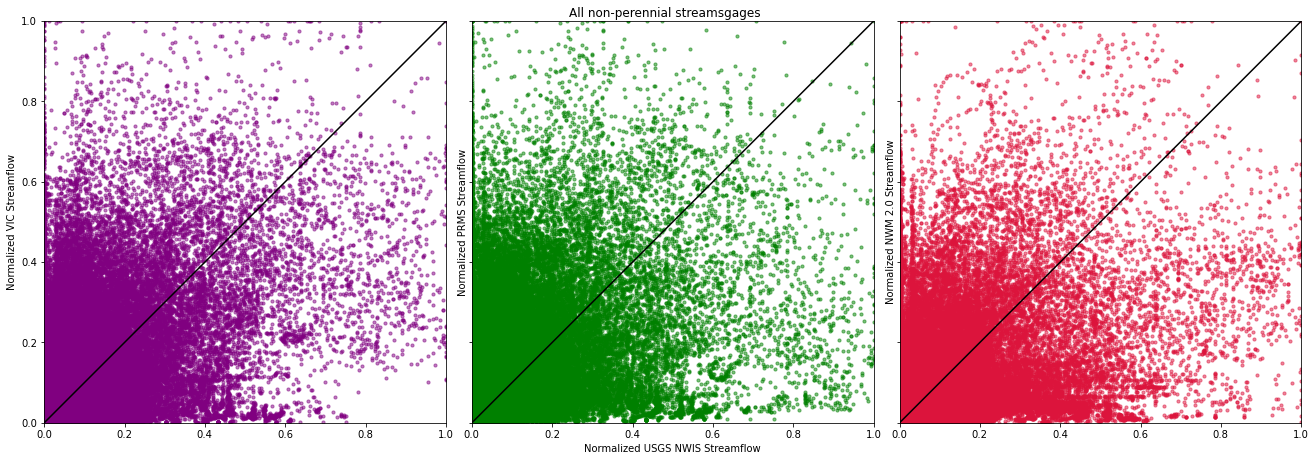

In [12]:
fig, axs = plt.subplots(1,3, sharey=True,figsize=(18,6),subplot_kw=dict(box_aspect=1))
fig.suptitle("All non-perennial streamsgages")


pt = (0, 0)
plt.tight_layout(pad=0.4, w_pad=1, h_pad=0.5)
axs[0].scatter(x = df["streamflow_NWIS"],y=df["streamflow_VIC"],alpha = 0.5,color = "purple",s=10)
axs[1].scatter(x = df["streamflow_NWIS"],y=df["streamflow_PRMS"],alpha = 0.5,color = 'green',s=10)
axs[2].scatter(x = df["streamflow_NWIS"],y=df["streamflow_NWM2d0"],alpha = 0.5,color = 'crimson',s=10)
axs[0].axline(pt,slope=1, color='black')
axs[1].axline(pt,slope=1, color='black')
axs[2].axline(pt,slope=1, color='black')
axs[0].set_ylabel('Normalized VIC Streamflow')
axs[1].set_ylabel('Normalized PRMS Streamflow')
axs[2].set_ylabel('Normalized NWM 2.0 Streamflow')
axs[1].set_xlabel('Normalized USGS NWIS Streamflow')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,1)
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,1)
axs[2].set_ylim(0,1)
axs[2].set_xlim(0,1)

plt.show()

In [25]:
# df = df[df['streamflow_NWIS']<=0.25]
df["NWMdiff"] = df['streamflow_NWIS'] - df['streamflow_NWM2d0']
df["PRMSdiff"] = df['streamflow_NWIS'] - df['streamflow_PRMS']
df["VICdiff"] = df['streamflow_NWIS'] - df['streamflow_VIC']

(array([8.74138978e-04, 3.93362540e-04, 2.92836558e-03, 7.82354386e-03,
        2.88028793e-02, 7.55693147e-02, 2.52451337e-01, 3.44554990e+00,
        3.94315352e+00, 2.62503935e-01]),
 array([-1.        , -0.8753125 , -0.75062501, -0.62593751, -0.50125001,
        -0.37656251, -0.25187502, -0.12718752, -0.00250002,  0.12218748,
         0.24687497]),
 <BarContainer object of 10 artists>)

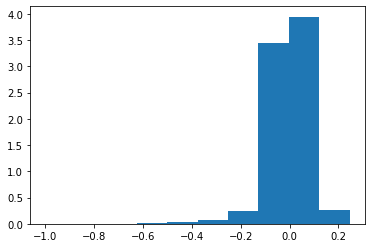

In [26]:
plt.hist(df['NWMdiff'],density=True)

(array([1.13823116e-03, 1.61979050e-03, 6.30404952e-03, 1.58914582e-02,
        5.06512868e-02, 1.42191339e-01, 5.48058305e-01, 3.73261021e+00,
        3.28182689e+00, 2.52818653e-01]),
 array([-1.        , -0.87551521, -0.75103043, -0.62654564, -0.50206086,
        -0.37757607, -0.25309129, -0.1286065 , -0.00412172,  0.12036307,
         0.24484785]),
 <BarContainer object of 10 artists>)

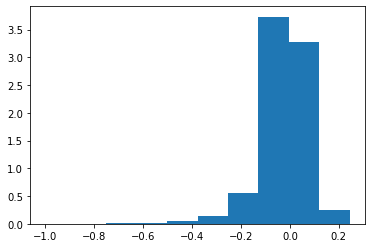

In [27]:
plt.hist(df['VICdiff'],density=True)

(array([2.15408142e-03, 2.28596396e-03, 7.16561780e-03, 1.82437508e-02,
        6.03142799e-02, 1.71755023e-01, 5.99054440e-01, 4.10655841e+00,
        2.92414355e+00, 1.74964165e-01]),
 array([-1.        , -0.87603264, -0.75206527, -0.62809791, -0.50413055,
        -0.38016319, -0.25619582, -0.13222846, -0.0082611 ,  0.11570627,
         0.23967363]),
 <BarContainer object of 10 artists>)

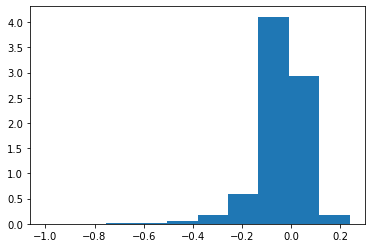

In [28]:
plt.hist(df['PRMSdiff'],density=True)

In [102]:
tt = df
tt["NWM_diff"] = tt['streamflow_NWM2d0']- tt['streamflow_NWIS']
tt["PRMS_diff"] = tt['streamflow_PRMS']- tt['streamflow_NWIS']
tt["VIC_diff"] = tt['streamflow_VIC']- tt['streamflow_NWIS']
tt = tt.drop(["streamflow_NWM2d0","streamflow_PRMS",'streamflow_VIC'],axis=1)

df01 = tt[tt['streamflow_NWIS']<=0.1]
df05 = tt[tt['streamflow_NWIS']<=0.05]
df10 = tt[tt['streamflow_NWIS']<=0.10]
df15 = tt[tt['streamflow_NWIS']<=0.15]
df20 = tt[tt['streamflow_NWIS']<=0.20]
df25 = tt[tt['streamflow_NWIS']<=0.25]
df30 = tt[tt['streamflow_NWIS']<=0.30]
df40 = tt[tt['streamflow_NWIS']<=0.40]
df50 = tt[tt['streamflow_NWIS']<=0.50]


dfAll = pd.concat([df01,df05,df10,df15,df20,df25,df30,df40,df50],axis=1)
dfAll = dfAll.drop(["streamflow_NWIS","time"],axis=1)
#                  keys = ['streamflow_NWIS','NWM_diff01','PRMS_diff01','VIC_diff01'
#                         ])




# tt = df[['NWMdiff','VICdiff','PRMSdiff']]

In [103]:
dfAll

,NWM_diff,PRMS_diff,VIC_diff,NWM_diff,PRMS_diff,VIC_diff,NWM_diff,PRMS_diff,VIC_diff,NWM_diff,...,VIC_diff,NWM_diff,PRMS_diff,VIC_diff,NWM_diff,PRMS_diff,VIC_diff,NWM_diff,PRMS_diff,VIC_diff
0,0.001483,0.002555,0.001006,0.001483,0.002555,0.001006,0.001483,0.002555,0.001006,0.001483,...,0.001006,0.001483,0.002555,0.001006,0.001483,0.002555,0.001006,0.001483,0.002555,0.001006
1,0.001464,0.002373,0.000974,0.001464,0.002373,0.000974,0.001464,0.002373,0.000974,0.001464,...,0.000974,0.001464,0.002373,0.000974,0.001464,0.002373,0.000974,0.001464,0.002373,0.000974
2,0.001352,0.002138,0.000848,0.001352,0.002138,0.000848,0.001352,0.002138,0.000848,0.001352,...,0.000848,0.001352,0.002138,0.000848,0.001352,0.002138,0.000848,0.001352,0.002138,0.000848
3,0.001511,0.002218,0.001025,0.001511,0.002218,0.001025,0.001511,0.002218,0.001025,0.001511,...,0.001025,0.001511,0.002218,0.001025,0.001511,0.002218,0.001025,0.001511,0.002218,0.001025
4,0.001507,0.002121,0.001017,0.001507,0.002121,0.001017,0.001507,0.002121,0.001017,0.001507,...,0.001017,0.001507,0.002121,0.001017,0.001507,0.002121,0.001017,0.001507,0.002121,0.001017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194287,-0.003541,-0.002769,0.009153,-0.003541,-0.002769,0.009153,-0.003541,-0.002769,0.009153,-0.003541,...,0.009153,-0.003541,-0.002769,0.009153,-0.003541,-0.002769,0.009153,-0.003541,-0.002769,0.009153
194288,-0.049925,0.081291,0.060698,NaN,NaN,NaN,-0.049925,0.081291,0.060698,-0.049925,...,0.060698,-0.049925,0.081291,0.060698,-0.049925,0.081291,0.060698,-0.049925,0.081291,0.060698
194289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004615,-0.160476,0.058259,0.004615,-0.160476,0.058259,0.004615,-0.160476,0.058259,0.004615
194290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.063514,-0.165922,-0.021597,-0.063514,-0.165922,-0.021597,-0.063514,-0.165922,-0.021597,-0.063514


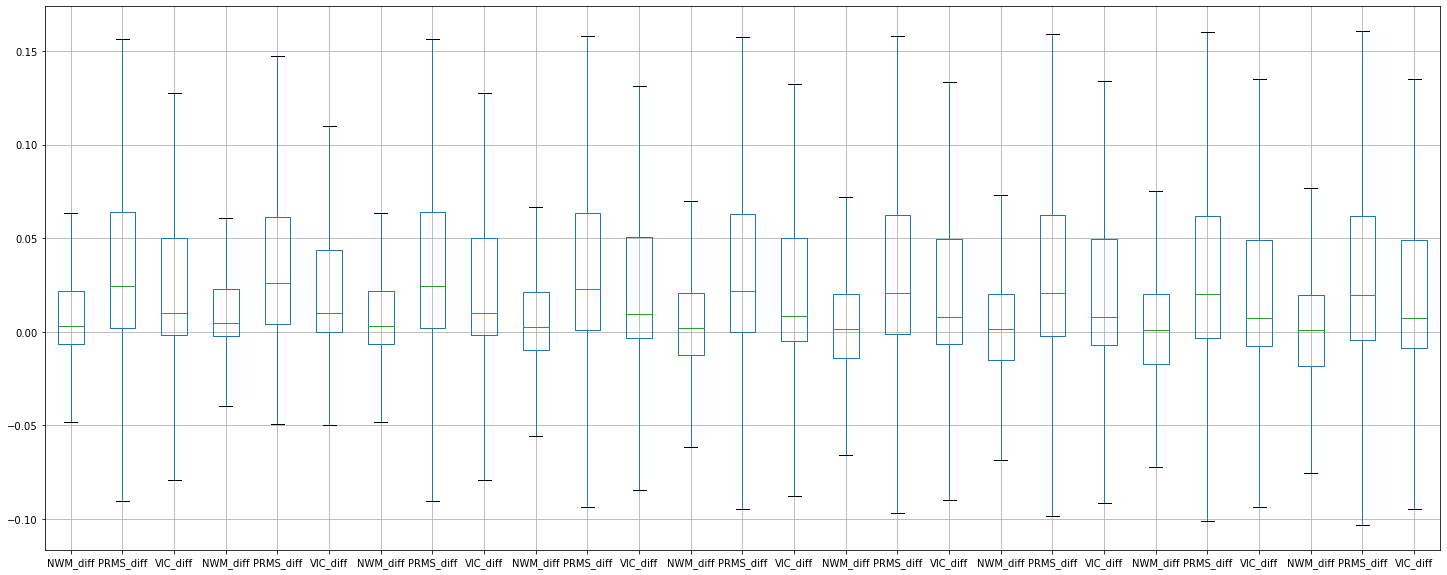

In [119]:
ax = dfAll.boxplot(showfliers=False,figsize = (25,10))

    
plt.show()

In [62]:
from scipy.stats import percentileofscore
import pandas as pd

# generate example data
arr = np.random.normal(0, 1, 10)

# pre-sort array
arr_sorted =  sorted(df)

# calculate percentiles using scipy func percentileofscore on each array element
s = pd.Series(arr)
percentiles = s.apply(lambda x: percentileofscore(arr_sorted, x))


In [65]:
df = pd.DataFrame({'data': s, 'percentiles': percentiles})    
df.sort_values(by='data')

,data,percentiles
5,-1.112743,10.0
2,-0.989881,20.0
9,-0.968817,30.0
1,-0.795401,40.0
4,-0.426059,50.0
3,0.204301,60.0
0,0.588358,70.0
7,0.869195,80.0
6,1.002681,90.0
8,1.783041,100.0


In [75]:
df.loc[:, 'streamflow_NWIS'] = df.rank(pct=True) # will be in decimal form

In [76]:
df

,time,streamflow_VIC,streamflow_PRMS,streamflow_NWM2d0,streamflow_NWIS
0,1993-01-01,0.001062,0.002611,0.001539,0.169572
1,1993-01-02,0.001049,0.002448,0.001539,0.172224
2,1993-01-03,0.001034,0.002324,0.001539,0.189059
3,1993-01-04,0.001025,0.002218,0.001511,0.071729
4,1993-01-05,0.001017,0.002121,0.001507,0.071729
...,...,...,...,...,...
194287,2011-12-27,0.029319,0.017397,0.016625,0.501951
194288,2011-12-28,0.131873,0.152465,0.021250,0.760559
194289,2011-12-29,0.196786,0.250429,0.031695,0.920042
194290,2011-12-30,0.148823,0.190740,0.046415,0.932840
